In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm

## Dataset

In [3]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()]  # applies a re-scaling [0,256] -> [0,1]
)
train_val = MNIST(
    os.getcwd(), train=True, transform=transform, target_transform=None, download=True
)
trainset, valset = random_split(train_val, [0.8, 0.2])
testset = MNIST(
    os.getcwd(), train=False, transform=transform, target_transform=None, download=True
)

dataloaders = {
    split: DataLoader(dataset, batch_size)
    for split, dataset in zip(["train", "val", "test"], [trainset, valset, testset])
}

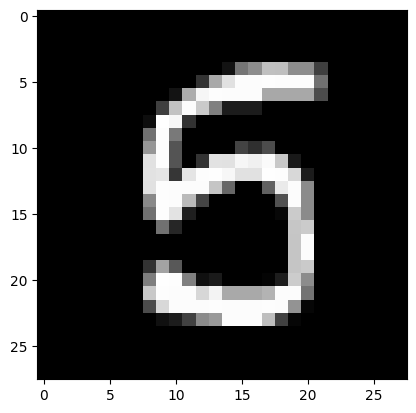

In [4]:
plt.imshow(trainset[0][0].permute(1, 2, 0), cmap="gray")

## Bernoulli RBM

In [5]:
class RBM(nn.Module):
    def __init__(self, nv: int, nh: int, k: int):
        super().__init__()
        self.W = nn.Parameter(torch.randn(nh, nv))
        self.vb = nn.Parameter(torch.randn(1, nv))
        self.hb = nn.Parameter(torch.randn(1, nh))
        self.k = k

    def v_to_h(self, v):
        ph = torch.sigmoid(F.linear(v, self.W, self.hb))
        return ph.bernoulli()

    def h_to_v(self, h):
        pv = torch.sigmoid(F.linear(h, self.W.t(), self.vb))
        return pv.bernoulli()

    def free_energy(self, v):
        v_term = v @ self.vb.t()
        h_term = torch.sum(F.softplus(F.linear(v, self.W, self.hb)), dim=1)
        return torch.mean(-v_term - h_term)

    def forward(self, v, k=None):
        k = k if k else self.k
        with torch.no_grad():
            h = self.v_to_h(v)
            for _ in range(k):
                v_gibb = self.h_to_v(h)
                h = self.v_to_h(v_gibb)
            return v_gibb

## CD training from Hinton, 2002

In [7]:
nv = 28 * 28
nh = 128
k = 5
model = RBM(nv, nh, k)
model.train()

dataloader = dataloaders["train"]

lr = 0.01
n_epochs = 10

optimizer = optim.Adam(model.parameters(), lr)

for epoch in range(n_epochs):
    losses = []
    for data, target in tqdm(dataloader):
        v = data.view(-1, 28 * 28)
        # CD from Hinton, 2002
        v_gibbs = model(v)
        pos_phase = model.free_energy(v)
        neg_phase = model.free_energy(v_gibbs)
        cd_loss = pos_phase - neg_phase
        losses.append(cd_loss.item())
        optimizer.zero_grad()
        cd_loss.backward()
        optimizer.step()

    print(f"{epoch=} loss={np.mean(losses)}")

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:11<00:00, 133.62it/s]


epoch=0 loss=46.08928129577637


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 120.63it/s]


epoch=1 loss=1.0754083353678385


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 124.23it/s]


epoch=2 loss=1.3846648406982422


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:13<00:00, 114.07it/s]


epoch=3 loss=1.6265471750895182


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:12<00:00, 118.18it/s]


epoch=4 loss=2.0508765767415365


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 146.47it/s]


epoch=5 loss=2.4685640563964846


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 148.43it/s]


epoch=6 loss=2.682504669189453


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 147.93it/s]


epoch=7 loss=2.762895202636719


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:11<00:00, 129.75it/s]


epoch=8 loss=2.8081546325683595


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:11<00:00, 126.10it/s]

epoch=9 loss=2.8547022298177085


## Reconstruction

In [8]:
def imshow(v_flat):
    # C, H, W -> H, W, C
    plt.imshow(make_grid(v_flat.view(batch_size, 1, 28, 28)).permute(1, 2, 0))

In [9]:
v = next(iter(dataloaders["test"]))[0]
v_gibbs = model(v.view(-1, 28 * 28))

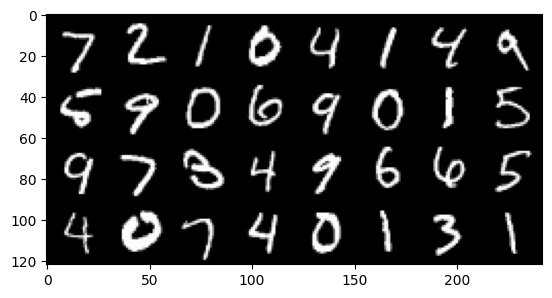

In [10]:
imshow(v)

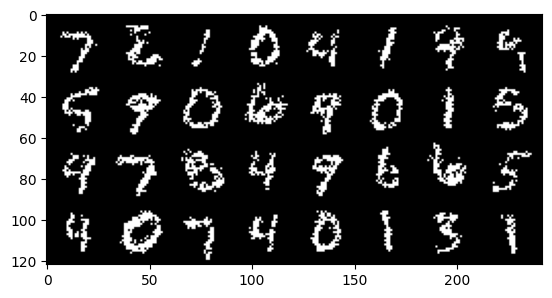

In [11]:
imshow(v_gibbs)

## Crude "denoising"

In [14]:
v_noise = v[0] + 0.5 * torch.randn_like(v[0])

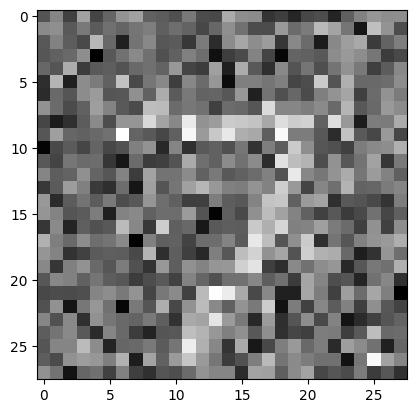

In [15]:
plt.imshow(v_noise.permute(1, 2, 0), cmap="gray")

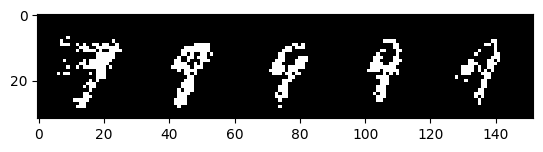

In [16]:
v_gibbs = v_noise.view(-1, 28 * 28)

samples = []
n_samples, step = 5, 5
for k in range(1, step * n_samples + 1, step):
    v_gibbs = model(v_gibbs, k=k)
    samples.append(v_gibbs)

plt.imshow(
    make_grid(torch.cat(samples, dim=0).view(n_samples, 1, 28, 28)).permute(1, 2, 0)
)

## "imputation"

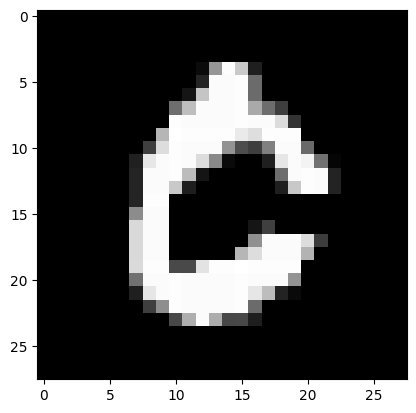

In [26]:
vi = int(np.random.rand() * len(v))
v_occ = transforms.RandomErasing()(v[vi])
plt.imshow(v_occ.view(1, 28, 28).permute(1, 2, 0), cmap="gray")

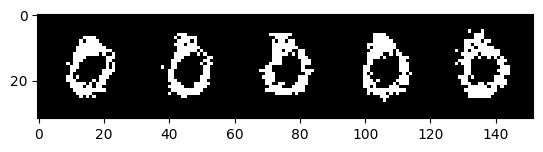

In [27]:
v_gibbs = v_occ.view(-1, 28 * 28)

samples = []
n_samples, step = 5, 5
for k in range(1, step * n_samples + 1, step):
    v_gibbs = model(v_gibbs, k=k)
    samples.append(v_gibbs)

plt.imshow(
    make_grid(torch.cat(samples, dim=0).view(n_samples, 1, 28, 28)).permute(1, 2, 0)
)